In [65]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns

### Carregar DataFrame e Verificação das Colunas
- Carregar o dataframe no ambiente de trabalho.
- Verificar as colunas presentes no dataframe para garantir que todos os dados necessários estão disponíveis.


In [3]:
dataset = pd.read_csv('dataset_I219.csv',
                    sep=',', 
                    encoding='latin1', 
                    on_bad_lines='warn', 
                    low_memory=False)

In [4]:
dataset.head()

,CONTADOR,ORIGEM,TIPOBITO,DTOBITO,HORAOBITO,NATURAL,DTNASC,IDADE,SEXO,RACACOR,...,VERSAOSIST,VERSAOSCB,ATESTADO,NUDIASOBCO,FONTES,TPRESGINFO,TPNIVELINV,NUDIASINF,FONTESINF,ALTCAUSA
0,2.0,1,2,6082010,1300,812.0,20011912.0,498.0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,26.0,1,2,14042010,1741,813.0,21041939.0,470.0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,27.0,1,2,4052010,0930,812.0,16041963.0,447.0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,35.0,1,2,24052010,0815,NaN,31011977.0,433.0,1,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,41.0,1,2,23012010,NaN,812.0,13111945.0,464.0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
dataset.columns

Index(['CONTADOR', 'ORIGEM', 'TIPOBITO', 'DTOBITO', 'HORAOBITO', 'NATURAL',
       'DTNASC', 'IDADE', 'SEXO', 'RACACOR', 'ESTCIV', 'ESC', 'OCUP',
       'CODMUNRES', 'LOCOCOR', 'CODESTAB', 'CODMUNOCOR', 'IDADEMAE', 'ESCMAE',
       'OCUPMAE', 'QTDFILVIVO', 'QTDFILMORT', 'GRAVIDEZ', 'GESTACAO', 'PARTO',
       'OBITOPARTO', 'PESO', 'OBITOGRAV', 'OBITOPUERP', 'ASSISTMED', 'EXAME',
       'CIRURGIA', 'NECROPSIA', 'LINHAA', 'LINHAB', 'LINHAC', 'LINHAD',
       'LINHAII', 'CAUSABAS', 'DTATESTADO', 'CIRCOBITO', 'ACIDTRAB', 'FONTE',
       'TPPOS', 'DTINVESTIG', 'CAUSABAS_O', 'DTCADASTRO', 'ATESTANTE',
       'FONTEINV', 'DTRECEBIM', 'UFINFORM', 'CB_PRE', 'MORTEPARTO', 'DTCADINF',
       'TPOBITOCOR', 'DTCADINV', 'COMUNSVOIM', 'DTRECORIG', 'DTRECORIGA',
       'CAUSAMAT', 'ESC2010', 'ESCMAE2010', 'STDOEPIDEM', 'STDONOVA',
       'CODMUNCART', 'NUMREGCART', 'DTREGCART', 'SERIESCFAL', 'ESCMAEAGR1',
       'ESCFALAGR1', 'SERIESCMAE', 'SEMAGESTAC', 'TPMORTEOCO', 'EXPDIFDATA',
       'DIFDATA', 'D

### Limpeza do DataFrame
- Selecionar e filtrar as colunas principais.
- Verificar a existência de linhas nulas.
- Verificar o tipo de dado de cada coluna no dataframe.
- Verificar as informações fornecidas pelo dataframe.


In [7]:
# Colunas que serão utilizadas 

colunas_base = [
    'TIPOBITO', 'IDADE', 'SEXO', 
    'LINHAA', 'LINHAB', 'LINHAC', 
    'LINHAD', 'LINHAII', 'CAUSABAS', 
    'CAUSABAS_O', 'RACACOR', 'ESC', 
    'ATESTADO','DTOBITO','CODMUNRES',"CODMUNOCOR"
]

# Verificar se as colunas existem no dataset antes de filtrar
colunas_existentes = [col for col in colunas_base if col in dataset.columns]

# Filtrar o DataFrame para manter apenas as colunas existentes
dataset_filtrado = dataset[colunas_existentes]

# Exibir as primeiras linhas do dataset filtrado
print(dataset_filtrado.head())

   TIPOBITO  IDADE  SEXO LINHAA LINHAB LINHAC LINHAD LINHAII CAUSABAS  \
0         2  498.0     1  *I469  *I219    NaN    NaN     NaN     I219   
1         2  470.0     1  *I219    NaN    NaN    NaN     NaN     I219   
2         2  447.0     1  *I219  *I200  *I516    NaN     NaN     I219   
3         2  433.0     1  *I219    NaN    NaN    NaN     NaN     I219   
4         2  464.0     1  *I219    NaN    NaN    NaN     NaN     I219   

  CAUSABAS_O  RACACOR  ESC ATESTADO   DTOBITO  CODMUNRES  CODMUNOCOR  
0        R98      NaN  2.0      NaN   6082010     120040      120040  
1       I219      NaN  NaN      NaN  14042010     120045      120045  
2       I219      NaN  NaN      NaN   4052010     120045      120045  
3       I219      4.0  3.0      NaN  24052010     120040      120040  
4        R98      NaN  NaN      NaN  23012010     120040      120040  


### Coluna Idade
- Através da análise da documentação do dataframe do SIM, desenvolvi uma função para decodificar a idade no dataframe, tornando o dado mais fácil de entender.

In [9]:
def transformar_idade(codigo_idade):
    if pd.isna(codigo_idade):  # Tratamento para valores nulos
        return None
    
    codigo_idade = str(int(codigo_idade)).zfill(3)  # Converte para string e preenche com zeros se necessário
    
    unidade = int(codigo_idade[0])  # Primeiro dígito (unidade)
    quantidade = int(codigo_idade[1:])  # Últimos dois dígitos (quantidade)
    
    if unidade == 0:  # Menor de 1 hora
        return quantidade / (60 * 24 * 365)  # Convertido para anos
    elif unidade == 1:  # Horas
        return quantidade / (24 * 365)  # Convertido para anos
    elif unidade == 2:  # Dias
        return quantidade / 365  # Convertido para anos
    elif unidade == 3:  # Meses
        return quantidade / 12  # Convertido para anos
    elif unidade == 4:  # Anos
        return quantidade  # Já está em anos
    elif unidade == 5:  # Anos (100 ou mais)
        return 100 + quantidade
    else:
        return None  # Caso inválido

In [10]:
# Criar uma cópia do DataFrame filtrado
dataset_filtrado1 = dataset_filtrado.copy()

# Aplicar a transformação
dataset_filtrado1['idade_real'] = dataset_filtrado1['IDADE'].apply(transformar_idade)

# Remover a coluna IDADE do DataFrame
dataset_filtrado1 = dataset_filtrado1.drop(columns=['IDADE'])


In [11]:
dataset_filtrado1.head()

,TIPOBITO,SEXO,LINHAA,LINHAB,LINHAC,LINHAD,LINHAII,CAUSABAS,CAUSABAS_O,RACACOR,ESC,ATESTADO,DTOBITO,CODMUNRES,CODMUNOCOR,idade_real
0,2,1,*I469,*I219,NaN,NaN,NaN,I219,R98,NaN,2.0,NaN,6082010,120040,120040,98.0
1,2,1,*I219,NaN,NaN,NaN,NaN,I219,I219,NaN,NaN,NaN,14042010,120045,120045,70.0
2,2,1,*I219,*I200,*I516,NaN,NaN,I219,I219,NaN,NaN,NaN,4052010,120045,120045,47.0
3,2,1,*I219,NaN,NaN,NaN,NaN,I219,I219,4.0,3.0,NaN,24052010,120040,120040,33.0
4,2,1,*I219,NaN,NaN,NaN,NaN,I219,R98,NaN,NaN,NaN,23012010,120040,120040,64.0


### Coluna de Data de Óbito
- Separar a data em dia, mês e ano.

In [13]:
def separar_data(data):
    data = str(data).zfill(8)  # Garante que tenha 8 dígitos, preenchendo com zeros à esquerda se necessário
    dia = data[:2]
    mes = data[2:4]
    ano = data[4:]
    return pd.Series([dia, mes, ano])

In [14]:
dataset_filtrado1[['DIA_OBITO', 'MES_OBITO', 'ANO_OBITO']] = dataset['DTOBITO'].apply(separar_data)

In [15]:
dataset_filtrado1.head()

,TIPOBITO,SEXO,LINHAA,LINHAB,LINHAC,LINHAD,LINHAII,CAUSABAS,CAUSABAS_O,RACACOR,ESC,ATESTADO,DTOBITO,CODMUNRES,CODMUNOCOR,idade_real,DIA_OBITO,MES_OBITO,ANO_OBITO
0,2,1,*I469,*I219,NaN,NaN,NaN,I219,R98,NaN,2.0,NaN,6082010,120040,120040,98.0,06,08,2010
1,2,1,*I219,NaN,NaN,NaN,NaN,I219,I219,NaN,NaN,NaN,14042010,120045,120045,70.0,14,04,2010
2,2,1,*I219,*I200,*I516,NaN,NaN,I219,I219,NaN,NaN,NaN,4052010,120045,120045,47.0,04,05,2010
3,2,1,*I219,NaN,NaN,NaN,NaN,I219,I219,4.0,3.0,NaN,24052010,120040,120040,33.0,24,05,2010
4,2,1,*I219,NaN,NaN,NaN,NaN,I219,R98,NaN,NaN,NaN,23012010,120040,120040,64.0,23,01,2010


### Arrumando a Coluna CODMUNOCOR  

#### Objetivo  
- Nesta coluna, está presente o código do município.  
- Utilizando uma tabela fornecida pelo IBGE, contendo o código do município e seu respectivo estado, será feita uma modificação para melhor compreensão.  
- Separação da informação em duas colunas: **Estado** e **Município**.  

In [17]:
# Dicionário de UFs baseado nos códigos IBGE
ufs = {
    "12": "Acre",
    "27": "Alagoas",
    "13": "Amazonas",
    "16": "Amapá",
    "29": "Bahia",
    "23": "Ceará",
    "53": "Distrito Federal",
    "32": "Espírito Santo",
    "52": "Goiás",
    "21": "Maranhão",
    "31": "Minas Gerais",
    "50": "Mato Grosso do Sul",
    "51": "Mato Grosso",
    "15": "Pará",
    "25": "Paraíba",
    "41": "Paraná",
    "26": "Pernambuco",
    "22": "Piauí",
    "33": "Rio de Janeiro",
    "24": "Rio Grande do Norte",
    "43": "Rio Grande do Sul",
    "11": "Rondônia",
    "14": "Roraima",
    "42": "Santa Catarina",
    "35": "São Paulo",
    "28": "Sergipe",
    "17": "Tocantins"
}

In [18]:
# Função para obter o estado pelo código do município
def get_estado(codigo_municipio):
    codigo_str = str(codigo_municipio)  # Converte para string
    uf_codigo = codigo_str[:2]  # Pega os dois primeiros dígitos
    return ufs.get(uf_codigo, "Desconhecido")  # Retorna o estado ou "Desconhecido"

In [19]:
dataset_filtrado1["Estado"] = dataset_filtrado1["CODMUNOCOR"].astype(str).apply(get_estado)

In [20]:
dataset_filtrado1.head()

,TIPOBITO,SEXO,LINHAA,LINHAB,LINHAC,LINHAD,LINHAII,CAUSABAS,CAUSABAS_O,RACACOR,ESC,ATESTADO,DTOBITO,CODMUNRES,CODMUNOCOR,idade_real,DIA_OBITO,MES_OBITO,ANO_OBITO,Estado
0,2,1,*I469,*I219,NaN,NaN,NaN,I219,R98,NaN,2.0,NaN,6082010,120040,120040,98.0,06,08,2010,Acre
1,2,1,*I219,NaN,NaN,NaN,NaN,I219,I219,NaN,NaN,NaN,14042010,120045,120045,70.0,14,04,2010,Acre
2,2,1,*I219,*I200,*I516,NaN,NaN,I219,I219,NaN,NaN,NaN,4052010,120045,120045,47.0,04,05,2010,Acre
3,2,1,*I219,NaN,NaN,NaN,NaN,I219,I219,4.0,3.0,NaN,24052010,120040,120040,33.0,24,05,2010,Acre
4,2,1,*I219,NaN,NaN,NaN,NaN,I219,R98,NaN,NaN,NaN,23012010,120040,120040,64.0,23,01,2010,Acre


###  Análise de Variáveis  

#### Objetivo  
Verificar as principais doenças relacionadas secundariamente à mortalidade por **Infarto Agudo**.  

####  Criar Colunas Indicadoras (0 = Ausência, 1 = Presença) para:  
- **Obesidade**  
- **Hipertensão**  
- **Transtornos mentais e comportamentais devido ao uso de tabaco**  
- **Diabetes**  


In [22]:
frequencia_Linhaa = dataset_filtrado["LINHAA"].value_counts()

frequencia_LinhaB = dataset_filtrado["LINHAB"].value_counts()

frequencia_LinhaC = dataset_filtrado["LINHAC"].value_counts()

frequencia_LinhaD = dataset_filtrado["LINHAD"].value_counts()

frequencia_LinhaII = dataset_filtrado["LINHAII"].value_counts()


print("\nFrequência de LINHAA:")
print(frequencia_Linhaa.head(10))

print("\nFrequência de linhab:")
print(frequencia_LinhaB.head(10))

print("\nFrequência de linhac:")
print(frequencia_LinhaC.head(10))

print("Frequência de linhad:")
print(frequencia_LinhaD.head(10))

print("Frequência de linhaII:")
print(frequencia_LinhaII.head(10))



Frequência de LINHAA:
LINHAA
*I219    587900
*R570    197680
*R092     83766
*J81X     44144
*I469     24459
*J960     22199
*A419     13326
*I509     12376
*R688     11665
*J969     11116
Name: count, dtype: int64

Frequência de linhab:
LINHAB
*I219    378495
*I10X    111694
*I251     45912
*I509     30700
*R570     26424
*J81X     22915
*I500     22713
*I709     22107
*I259     17928
*R092     14706
Name: count, dtype: int64

Frequência de linhac:
LINHAC
*I219    113212
*I10X    107345
*I251     41487
*I709     23646
*I509     14785
*I500     12681
*I259     12120
*I248      9544
*I119      9307
*R570      7083
Name: count, dtype: int64
Frequência de linhad:
LINHAD
*I10X    50859
*I219    40974
*I251    13003
*I709    10695
*F172     3404
*I259     3381
*I509     3189
*I500     3031
*I248     2628
*R54X     2135
Name: count, dtype: int64
Frequência de linhaII:
LINHAII
*I10X         61391
*E149         26518
*I10X*E149    25751
*F172         11469
*E149*I10X     8603
*R54X          7

In [23]:
# Lista de CIDs relacionados à obesidade
cids_obesidade = [
    "E66", "E660", "E661", "E662", "E668", "E669",
    "Z680", "Z681", "Z682", "Z683", "Z684"
]

# Função para verificar se algum CID está presente em uma linha
def verificar_obesidade(row):
    for coluna in ['LINHAA', 'LINHAB', 'LINHAC', 'LINHAD', 'LINHAII', 'CAUSABAS_O']:
        if pd.notna(row[coluna]):  # Verifica se o valor não é NaN
            for cid in cids_obesidade:
                if cid in row[coluna]:
                    return 1  # Encontrou um CID relacionado
    return 0  # Não encontrou nenhum CID relacionado

# Aplicar a função para criar a nova coluna "obesidade"
dataset_filtrado1['obesidade'] = dataset_filtrado1.apply(verificar_obesidade, axis=1)

# Exibir as primeiras linhas do DataFrame atualizado
print(dataset_filtrado1[['LINHAA', 'LINHAB', 'LINHAC', 'LINHAD', 'LINHAII', 'CAUSABAS_O', 'obesidade']].head())


  LINHAA LINHAB LINHAC LINHAD LINHAII CAUSABAS_O  obesidade
0  *I469  *I219    NaN    NaN     NaN        R98          0
1  *I219    NaN    NaN    NaN     NaN       I219          0
2  *I219  *I200  *I516    NaN     NaN       I219          0
3  *I219    NaN    NaN    NaN     NaN       I219          0
4  *I219    NaN    NaN    NaN     NaN        R98          0


In [24]:
# Lista de CIDs relacionados à hipertensao
cids_hipertensao = ["I10X"]

# Função para verificar se algum CID está presente em uma linha
def verificar_hipertesao(row):
    for coluna in ['LINHAA', 'LINHAB', 'LINHAC', 'LINHAD', 'LINHAII', 'CAUSABAS_O']:
        if pd.notna(row[coluna]):  # Verifica se o valor não é NaN
            for cid in cids_hipertensao:
                if cid in row[coluna]:
                    return 1  # Encontrou um CID relacionado
    return 0  # Não encontrou nenhum CID relacionado

# Aplicar a função para criar a nova coluna "hipertesao"
dataset_filtrado1['hipertesao'] = dataset_filtrado1.apply(verificar_hipertesao, axis=1)

# Exibir as primeiras linhas do DataFrame atualizado
print(dataset_filtrado1.head())


   TIPOBITO  SEXO LINHAA LINHAB LINHAC LINHAD LINHAII CAUSABAS CAUSABAS_O  \
0         2     1  *I469  *I219    NaN    NaN     NaN     I219        R98   
1         2     1  *I219    NaN    NaN    NaN     NaN     I219       I219   
2         2     1  *I219  *I200  *I516    NaN     NaN     I219       I219   
3         2     1  *I219    NaN    NaN    NaN     NaN     I219       I219   
4         2     1  *I219    NaN    NaN    NaN     NaN     I219        R98   

   RACACOR  ...   DTOBITO CODMUNRES  CODMUNOCOR  idade_real  DIA_OBITO  \
0      NaN  ...   6082010    120040      120040        98.0         06   
1      NaN  ...  14042010    120045      120045        70.0         14   
2      NaN  ...   4052010    120045      120045        47.0         04   
3      4.0  ...  24052010    120040      120040        33.0         24   
4      NaN  ...  23012010    120040      120040        64.0         23   

   MES_OBITO ANO_OBITO Estado obesidade hipertesao  
0         08      2010   Acre         0

In [25]:
# Lista de CIDs relacionados à Diabetes
cids_Diabetes= ["E149"]

# Função para verificar se algum CID está presente em uma linha
def verificar_diabetes(row):
    for coluna in ['LINHAA', 'LINHAB', 'LINHAC', 'LINHAD', 'LINHAII', 'CAUSABAS_O']:
        if pd.notna(row[coluna]):  # Verifica se o valor não é NaN
            for cid in cids_Diabetes:
                if cid in row[coluna]:
                    return 1  # Encontrou um CID relacionado
    return 0  # Não encontrou nenhum CID relacionado

# Aplicar a função para criar a nova coluna "hipertesao"
dataset_filtrado1['diabetes'] = dataset_filtrado1.apply(verificar_diabetes, axis=1)

# Exibir as primeiras linhas do DataFrame atualizado
print(dataset_filtrado1.head())

   TIPOBITO  SEXO LINHAA LINHAB LINHAC LINHAD LINHAII CAUSABAS CAUSABAS_O  \
0         2     1  *I469  *I219    NaN    NaN     NaN     I219        R98   
1         2     1  *I219    NaN    NaN    NaN     NaN     I219       I219   
2         2     1  *I219  *I200  *I516    NaN     NaN     I219       I219   
3         2     1  *I219    NaN    NaN    NaN     NaN     I219       I219   
4         2     1  *I219    NaN    NaN    NaN     NaN     I219        R98   

   RACACOR  ...  CODMUNRES CODMUNOCOR  idade_real  DIA_OBITO  MES_OBITO  \
0      NaN  ...     120040     120040        98.0         06         08   
1      NaN  ...     120045     120045        70.0         14         04   
2      NaN  ...     120045     120045        47.0         04         05   
3      4.0  ...     120040     120040        33.0         24         05   
4      NaN  ...     120040     120040        64.0         23         01   

   ANO_OBITO Estado obesidade hipertesao diabetes  
0       2010   Acre         0     

In [26]:
# Lista de CIDs relacionados à Transtornos mentais e comportamentais devido ao uso de tabaco.
cids_tabaco = ['F172', 'F171', 'F179']

# Função para verificar se algum CID está presente em uma linha
def verificar_cid(row):
    for coluna in ['LINHAA', 'LINHAB', 'LINHAC', 'LINHAD', 'LINHAII', 'CAUSABAS_O']:
        if pd.notna(row[coluna]):  # Verifica se o valor não é NaN
            for cid in cids_tabaco:
                if cid in row[coluna]:
                    return 1  # Encontrou um CID relacionado
    return 0  # Não encontrou nenhum CID relacionado

# Aplicar a função para criar a nova coluna "hipertesao"
dataset_filtrado1['tmTabaco'] = dataset_filtrado1.apply(verificar_cid, axis=1)

# Exibir as primeiras linhas do DataFrame atualizado
print(dataset_filtrado1.head())

   TIPOBITO  SEXO LINHAA LINHAB LINHAC LINHAD LINHAII CAUSABAS CAUSABAS_O  \
0         2     1  *I469  *I219    NaN    NaN     NaN     I219        R98   
1         2     1  *I219    NaN    NaN    NaN     NaN     I219       I219   
2         2     1  *I219  *I200  *I516    NaN     NaN     I219       I219   
3         2     1  *I219    NaN    NaN    NaN     NaN     I219       I219   
4         2     1  *I219    NaN    NaN    NaN     NaN     I219        R98   

   RACACOR  ...  CODMUNOCOR idade_real  DIA_OBITO  MES_OBITO  ANO_OBITO  \
0      NaN  ...      120040       98.0         06         08       2010   
1      NaN  ...      120045       70.0         14         04       2010   
2      NaN  ...      120045       47.0         04         05       2010   
3      4.0  ...      120040       33.0         24         05       2010   
4      NaN  ...      120040       64.0         23         01       2010   

   Estado obesidade hipertesao diabetes tmTabaco  
0    Acre         0          0     

In [27]:
dataset_filtrado1.rename(columns={"hipertesao": "hipertensao"}, inplace=True)

In [28]:
dataset_filtrado1.head()

,TIPOBITO,SEXO,LINHAA,LINHAB,LINHAC,LINHAD,LINHAII,CAUSABAS,CAUSABAS_O,RACACOR,...,CODMUNOCOR,idade_real,DIA_OBITO,MES_OBITO,ANO_OBITO,Estado,obesidade,hipertensao,diabetes,tmTabaco
0,2,1,*I469,*I219,NaN,NaN,NaN,I219,R98,NaN,...,120040,98.0,06,08,2010,Acre,0,0,0,0
1,2,1,*I219,NaN,NaN,NaN,NaN,I219,I219,NaN,...,120045,70.0,14,04,2010,Acre,0,0,0,0
2,2,1,*I219,*I200,*I516,NaN,NaN,I219,I219,NaN,...,120045,47.0,04,05,2010,Acre,0,0,0,0
3,2,1,*I219,NaN,NaN,NaN,NaN,I219,I219,4.0,...,120040,33.0,24,05,2010,Acre,0,0,0,0
4,2,1,*I219,NaN,NaN,NaN,NaN,I219,R98,NaN,...,120040,64.0,23,01,2010,Acre,0,0,0,0


In [30]:
contagem_obesidade = dataset_filtrado1.groupby('obesidade').size().sort_values(ascending=False)
print(contagem_obesidade)
print('\n')
contagem_hipertensao = dataset_filtrado1.groupby('hipertensao').size().sort_values(ascending=False)
print(contagem_hipertensao)
print('\n')
contagem_diabetes = dataset_filtrado1.groupby('diabetes').size().sort_values(ascending=False)
print(contagem_diabetes)
print('\n')
contagem_tmtabaco = dataset_filtrado1.groupby('tmTabaco').size().sort_values(ascending=False)
print(contagem_tmtabaco)



obesidade
0    1129341
1      15639
dtype: int64


hipertensao
0    707685
1    437295
dtype: int64


diabetes
0    1050834
1      94146
dtype: int64


tmTabaco
0    1098845
1      46135
dtype: int64


In [31]:
dataset_filtrado1.to_csv('dataset_I219_Obesidade.csv', index=False)

### Dataset final 

In [33]:
dataset_filtrado2 = dataset_filtrado1.copy()

In [34]:
# Listar as colunas a serem deletadas
colunas_deletar = ['LINHAA', 'LINHAB', 'LINHAC', 'LINHAD', 'LINHAII', 'CAUSABAS_O','TIPOBITO','ATESTADO','CODMUNOCOR','DIA_OBITO','CODMUNRES']

# Deletar as colunas do dataset
dataset_filtrado2.drop(columns=colunas_deletar, inplace=True)

# Exibir as primeiras linhas para verificar se as colunas foram removidas
dataset_filtrado2.head()


,SEXO,CAUSABAS,RACACOR,ESC,DTOBITO,idade_real,MES_OBITO,ANO_OBITO,Estado,obesidade,hipertensao,diabetes,tmTabaco
0,1,I219,NaN,2.0,6082010,98.0,08,2010,Acre,0,0,0,0
1,1,I219,NaN,NaN,14042010,70.0,04,2010,Acre,0,0,0,0
2,1,I219,NaN,NaN,4052010,47.0,05,2010,Acre,0,0,0,0
3,1,I219,4.0,3.0,24052010,33.0,05,2010,Acre,0,0,0,0
4,1,I219,NaN,NaN,23012010,64.0,01,2010,Acre,0,0,0,0


In [35]:
dataset_filtrado2.drop(columns=['DTOBITO'], inplace=True)

In [36]:
dataset_filtrado2.head()

,SEXO,CAUSABAS,RACACOR,ESC,idade_real,MES_OBITO,ANO_OBITO,Estado,obesidade,hipertensao,diabetes,tmTabaco
0,1,I219,NaN,2.0,98.0,08,2010,Acre,0,0,0,0
1,1,I219,NaN,NaN,70.0,04,2010,Acre,0,0,0,0
2,1,I219,NaN,NaN,47.0,05,2010,Acre,0,0,0,0
3,1,I219,4.0,3.0,33.0,05,2010,Acre,0,0,0,0
4,1,I219,NaN,NaN,64.0,01,2010,Acre,0,0,0,0


In [37]:
dataset_filtrado2.to_csv('dataset_I219_Obesidade_colunasCorretas.csv', index=False)

### Analise Descritiva 

In [39]:
# Desvio Padrão
desvio_padrao_idade = dataset_filtrado2["idade_real"].std()

# Variância
variancia_idade = dataset_filtrado2["idade_real"].var()

# Intervalo Interquartil (IQR)
q1 = dataset_filtrado2["idade_real"].quantile(0.25)
q3 = dataset_filtrado2["idade_real"].quantile(0.75)
iqr_idade = q3 - q1

print(f"Desvio Padrão: {desvio_padrao_idade}")
print(f"Variância: {variancia_idade}")
print(f"IQR: {iqr_idade}")


Desvio Padrão: 14.594359916803338
Variância: 212.99534138119594
IQR: 21.0


In [40]:
# Transformar todos os valores da coluna CAUSAbaS em 1
dataset_filtrado2["CAUSABAS"] = 1

# Verificar se a transformação foi bem-sucedida
print(dataset_filtrado2["CAUSABAS"].unique())  

dataset_filtrado2.head()


[1]


,SEXO,CAUSABAS,RACACOR,ESC,idade_real,MES_OBITO,ANO_OBITO,Estado,obesidade,hipertensao,diabetes,tmTabaco
0,1,1,NaN,2.0,98.0,08,2010,Acre,0,0,0,0
1,1,1,NaN,NaN,70.0,04,2010,Acre,0,0,0,0
2,1,1,NaN,NaN,47.0,05,2010,Acre,0,0,0,0
3,1,1,4.0,3.0,33.0,05,2010,Acre,0,0,0,0
4,1,1,NaN,NaN,64.0,01,2010,Acre,0,0,0,0


In [41]:
# Frequência de obesidade
frequencia_obesidade = dataset_filtrado2["obesidade"].value_counts()

# Frequência de sexo
frequencia_sexo = dataset_filtrado2["SEXO"].value_counts()

# Frequência de Escolaridade
frequencia_esc = dataset_filtrado2["ESC"].value_counts()

#freuqencia de RACACOR
frequencia_racacor = dataset_filtrado2["RACACOR"].value_counts()

print("Frequência de obesidade:")
print(frequencia_obesidade)

print("\nFrequência de sexo:")
print(frequencia_sexo)

print("\nFrequência de escolaridade:")
print(frequencia_esc)

print("\nFrequência de RACACOR:")
print(frequencia_racacor)


Frequência de obesidade:
obesidade
0    1129341
1      15639
Name: count, dtype: int64

Frequência de sexo:
SEXO
1    676205
2    468655
0       105
9        15
Name: count, dtype: int64

Frequência de escolaridade:
ESC
2.0    278621
3.0    242939
1.0    201487
4.0    161361
9.0    122636
5.0     59331
0.0     14494
Name: count, dtype: int64

Frequência de RACACOR:
RACACOR
1.0    607284
4.0    404519
2.0     89136
3.0      6700
5.0      2190
Name: count, dtype: int64


In [42]:
# Agrupar por data e contar o número de óbitos
time_series = dataset_filtrado2 .groupby('ANO_OBITO').size()

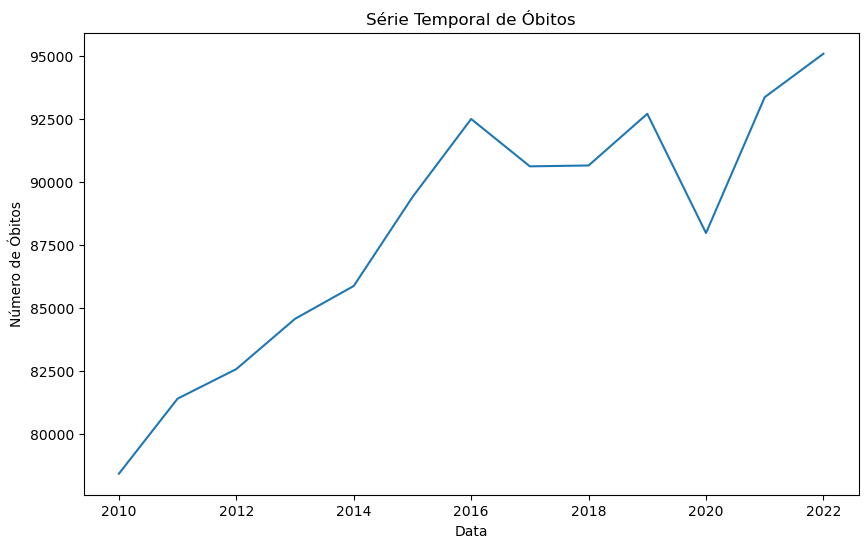

In [43]:
# Visualizar a série temporal
plt.figure(figsize=(10, 6))
time_series.plot()
plt.title('Série Temporal de Óbitos')
plt.xlabel('Data')
plt.ylabel('Número de Óbitos')
plt.show()

In [44]:
mortes_por_estado = dataset_filtrado2 .groupby('Estado').size()

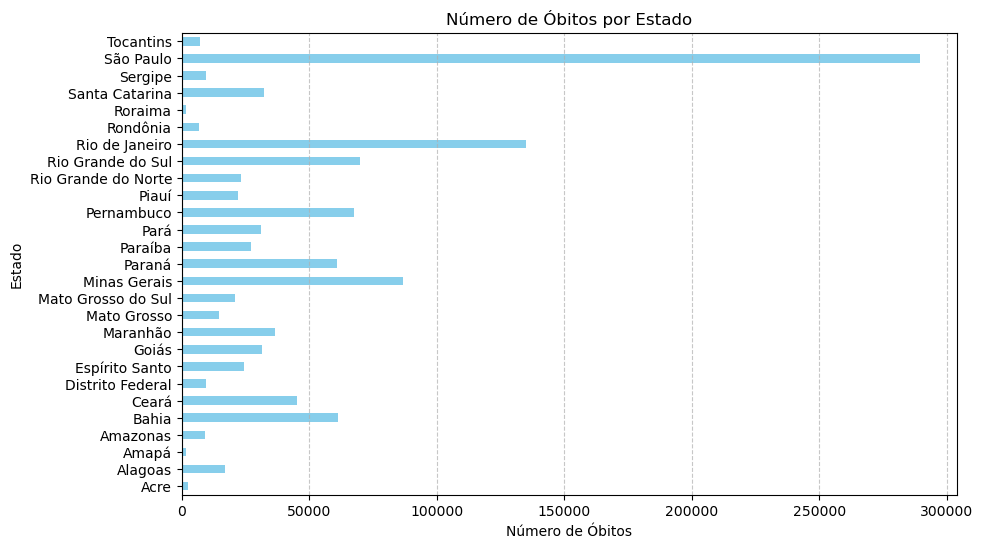

In [45]:
# Criar o gráfico de barras laterais
plt.figure(figsize=(10, 6))
mortes_por_estado.plot(kind='barh', color='skyblue')
plt.title('Número de Óbitos por Estado')
plt.xlabel('Número de Óbitos')
plt.ylabel('Estado')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

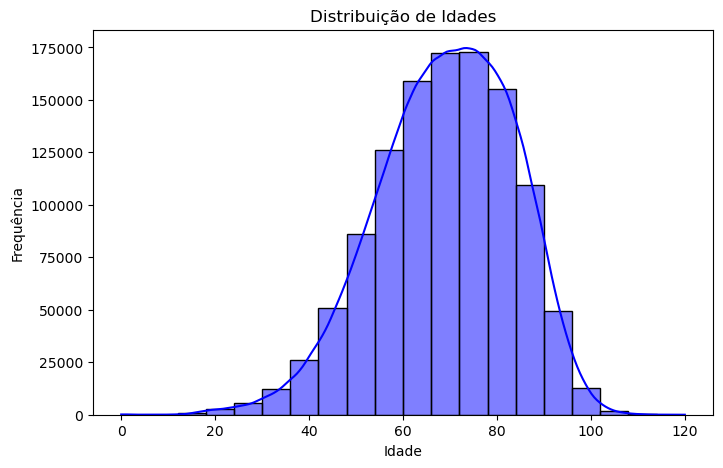

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histograma da distribuição de idades
plt.figure(figsize=(8, 5))
sns.histplot(dataset_filtrado2["idade_real"], bins=20, kde=True, color="blue")
plt.title("Distribuição de Idades")
plt.xlabel("Idade")
plt.ylabel("Frequência")
plt.show()

C:\Users\Vitor\AppData\Local\Temp\ipykernel_11288\4202512766.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="obesidade", y="idade_real", data=dataset_filtrado2, palette="coolwarm")


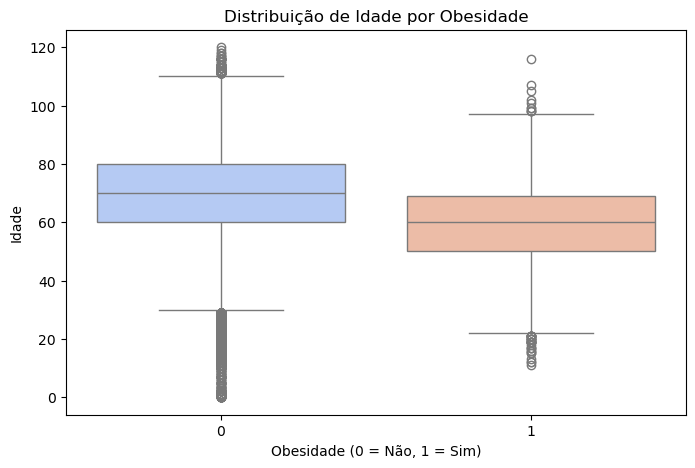

In [47]:
# Boxplot: Idade por obesidade
plt.figure(figsize=(8, 5))
sns.boxplot(x="obesidade", y="idade_real", data=dataset_filtrado2, palette="coolwarm")
plt.title("Distribuição de Idade por Obesidade")
plt.xlabel("Obesidade (0 = Não, 1 = Sim)")
plt.ylabel("Idade")
plt.show()

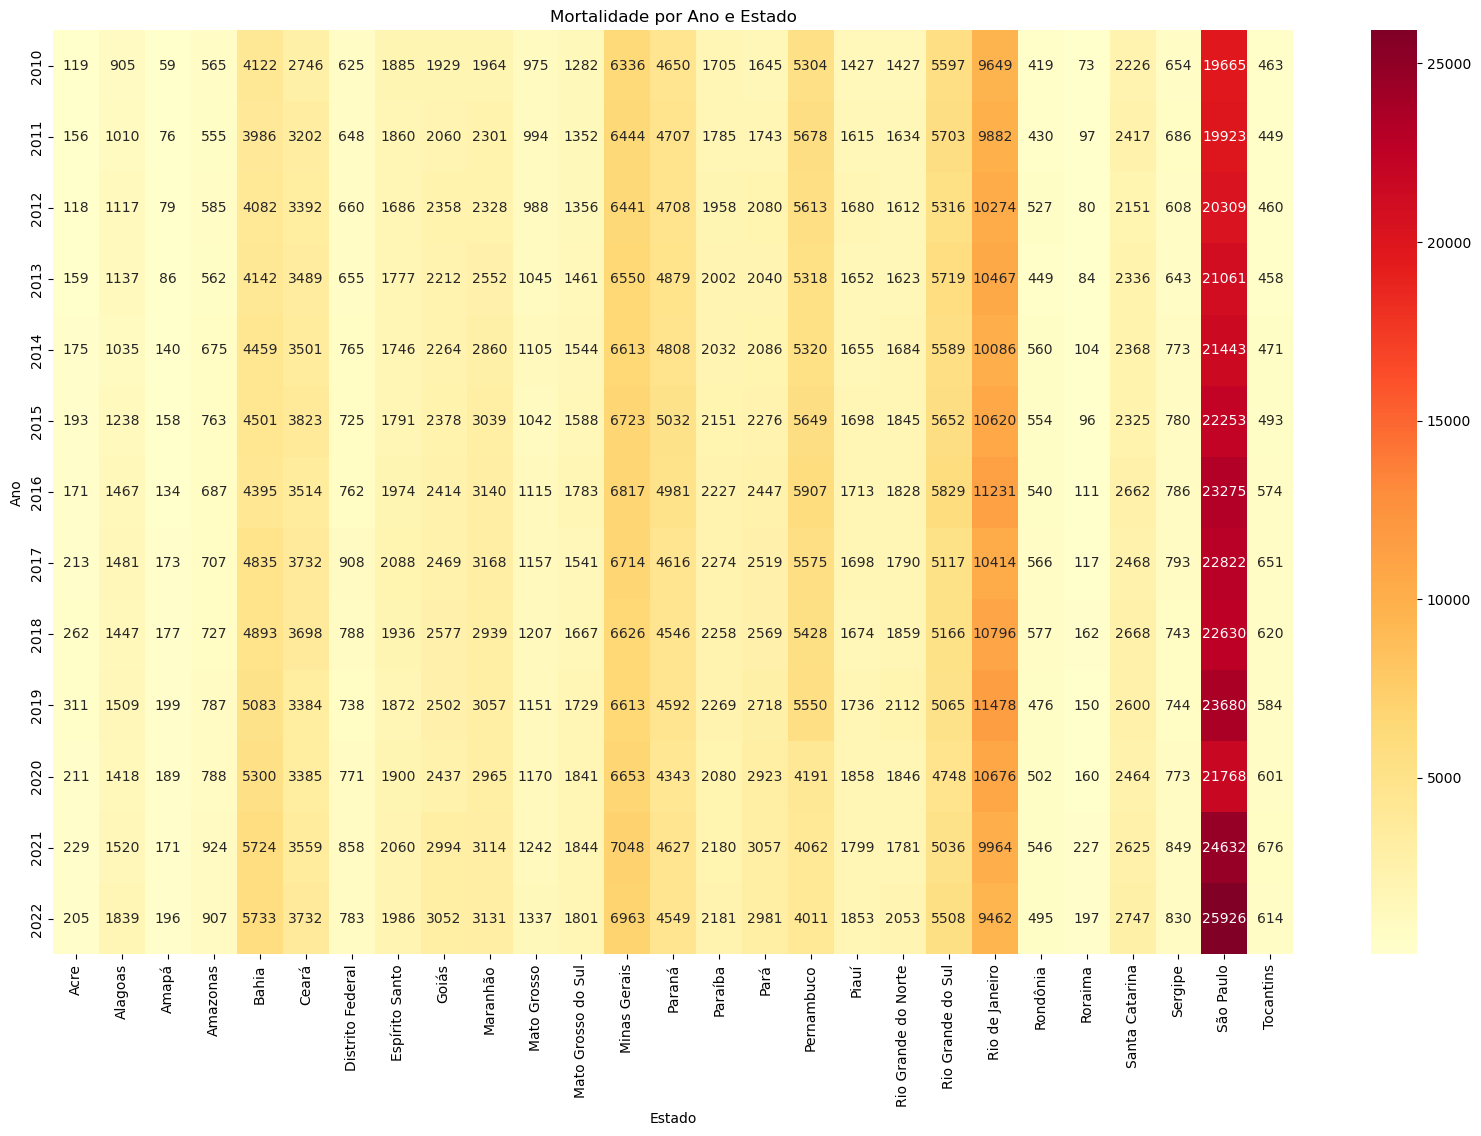

In [94]:
# Agrupar por ano e estado e contar o número de óbitos
mortalidade_ano_estado = dataset_filtrado2.groupby(['ANO_OBITO', 'Estado']).size().unstack()

# Visualizar os dados
plt.figure(figsize=(20, 12))
sns.heatmap(mortalidade_ano_estado, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Mortalidade por Ano e Estado')
plt.xlabel('Estado')
plt.ylabel('Ano')
plt.show()